In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
from datetime import datetime
from numpy import array
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import plot_model
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/H4TF 4 CON CÚ/Business Case 1/Data/HPG Data .csv', header=0, parse_dates=[0], index_col=0)

In [ ]:
data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-03-31,"18,909.0","18,909.0","19,000.0","18,500.0",26.15M,0.00%
2023-03-30,"18,909.0","19,091.0","19,227.0","18,864.0",23.05M,0.00%
2023-03-29,"18,909.0","18,818.0","19,182.0","18,818.0",19.74M,0.48%
2023-03-28,"18,818.0","19,000.0","19,091.0","18,818.0",13.56M,-0.48%
2023-03-27,"18,909.0","18,545.0","19,000.0","18,500.0",22.29M,1.96%


In [ ]:
data = data.sort_index()

In [ ]:
data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-01-02,"11,991.0","11,789.9","12,003.6","11,676.8",15.73M,1.81%
2018-01-03,"11,965.9","12,066.4","12,192.1","11,890.5",18.51M,-0.21%
2018-01-04,"12,116.7","12,016.2","12,167.0","11,965.9",17.79M,1.26%
2018-01-05,"12,066.4","12,091.6","12,179.6","11,978.4",14.03M,-0.42%
2018-01-08,"12,443.5","11,991.0","12,443.5","11,940.7",14.19M,3.13%


In [ ]:
data.index = pd.to_datetime(data.index, format='%m/%d/%Y')

columns_to_convert = ['Price', 'Open', 'High', 'Low']
for column in columns_to_convert:
    data[column] = data[column].astype(str).str.replace(',', '').astype(float)

data['Vol.'] = data['Vol.'].str.replace('M', '').astype(float)

data['Change %'] = data['Change %'].str.replace('%', '').astype(float)

In [ ]:
data.columns = ['Closing Price', 'Opening Price', 'Highest Price', 'Lowest Price', 'Trading Volume', 'Percentage Change']

In [ ]:
data.head()

,Closing Price,Opening Price,Highest Price,Lowest Price,Trading Volume,Percentage Change
Date,,,,,,
2018-01-02,11991.0,11789.9,12003.6,11676.8,15.73,1.81
2018-01-03,11965.9,12066.4,12192.1,11890.5,18.51,-0.21
2018-01-04,12116.7,12016.2,12167.0,11965.9,17.79,1.26
2018-01-05,12066.4,12091.6,12179.6,11978.4,14.03,-0.42
2018-01-08,12443.5,11991.0,12443.5,11940.7,14.19,3.13


In [ ]:
train = data['2018-01-02':'2022-02-28']
test = data['2022-03-01':'2023-03-31']

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

target_column = 'Closing Price'
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_target.fit(train[[target_column]])

MinMaxScaler()

In [ ]:
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)

In [ ]:
# train_data_scaled.shape, test_data_scaled.shape

In [ ]:
def create_dataset(dataset, time_step=20, target='Closing Price'):
    X, y = [], []
    target_idx = dataset.columns.get_loc(target)
    for i in range(time_step, len(dataset)):
        X.append(dataset.iloc[i-time_step:i].drop(target, axis=1).values)
        y.append(dataset.iloc[i, target_idx])
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = create_dataset(train_scaled, time_step=20, target='Closing Price')
X_test, y_test = create_dataset(test_scaled, time_step=20, target='Closing Price')

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1015, 20, 5), (1015,), (253, 20, 5), (253,))

In [ ]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))

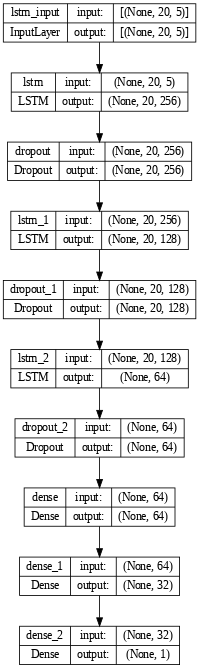

In [ ]:
plot_model(
    model, dpi=60,
    show_shapes=True
)

In [ ]:
initial_learning_rate = 0.001
lr_schedule = LearningRateScheduler(lambda epoch: initial_learning_rate * np.exp(-epoch / 100), verbose=1)
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model with Early Stopping and Learning Rate Scheduler
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, lr_schedule]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/200
32/32 [==============================] - 12s 204ms/step - loss: 0.9106 - val_loss: 0.7194 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000990049833749168.
Epoch 2/200
32/32 [==============================] - 4s 122ms/step - loss: 0.5944 - val_loss: 0.4797 - lr: 9.9005e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009801986733067552.
Epoch 3/200
32/32 [==============================] - 3s 109ms/step - loss: 0.3886 - val_loss: 0.3120 - lr: 9.8020e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009704455335485082.
Epoch 4/200
32/32 [==============================] - 4s 112ms/step - loss: 0.2513 - val_loss: 0.2032 - lr: 9.7045e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009607894391523232.
Epoch 5/200
32/32 [==============================] - 6s 176ms/step - loss: 0.1618 - val_loss: 0.1293 - lr: 9.6079e-04

Epoch 6: LearningRateSchedule

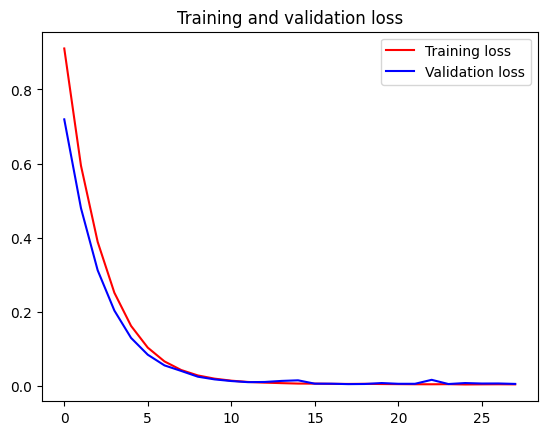

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 33ms/step


In [ ]:
train_pred=model.predict(X_train)
test_pred=model.predict(X_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test,test_pred)))

8/8 [==============================] - 0s 33ms/step
Train rmse: 0.03675616520414013
Validation rmse: 0.044625314564336445


In [ ]:
def inverse_transform_predictions(predictions, original_data, scaler, target_col_index):
    dummy_data = np.zeros((predictions.shape[0], original_data.shape[1]))
    dummy_data[:, target_col_index] = predictions[:, 0]
    inversed = scaler.inverse_transform(dummy_data)
    return inversed[:, target_col_index]

In [ ]:
train_predict_1 = inverse_transform_predictions(train_predict, train_scaled, scaler, train.columns.get_loc('Closing Price'))
test_predict_1 = inverse_transform_predictions(test_predict, test_scaled, scaler, test.columns.get_loc('Closing Price'))

# Inverse transform y_train và y_test để lấy giá trị thực
original_ytrain = inverse_transform_predictions(y_train.reshape(-1, 1), train_scaled, scaler, train.columns.get_loc('Closing Price'))
original_ytest = inverse_transform_predictions(y_test.reshape(-1, 1), test_scaled, scaler, test.columns.get_loc('Closing Price'))

In [ ]:
# train_predict_1 = scaler_target.inverse_transform(train_predict)
# test_predict_1 = scaler_target.inverse_transform(test_predict)
# original_ytrain = scaler_target.inverse_transform(y_train.reshape(-1, 1))
# original_ytest = scaler_target.inverse_transform(y_test.reshape(-1,1))

In [ ]:
train_predict_1

array([13611.37484311, 13836.36440556, 14027.84639953, ...,
       34457.09297209, 34602.72482162, 34702.6092773 ])

In [ ]:
original_ytrain

array([15334.4, 15359.6, 14328.9, ..., 34813.9, 34738.2, 35722.1])

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict_1))
print("Test data R2 score:", r2_score(original_ytest, test_predict_1))

Train data R2 score: 0.983612984126249
Test data R2 score: 0.8990887299985814


In [ ]:
train_mape = mean_absolute_percentage_error(original_ytrain, train_predict_1)
test_mape = mean_absolute_percentage_error(original_ytest, test_predict_1)
print("Train data MAPE: ", train_mape)
print("Test data MAPE: ", test_mape)

Train data MAPE:  0.05301747448317781
Test data MAPE:  0.06628901453547101


In [ ]:
train_rmse = np.sqrt(mean_squared_error(original_ytrain, train_predict_1))
test_rmse = mean_squared_error(original_ytest, test_predict_1)
print("Train data RMSE: ", train_rmse)
print("Test data RMSE: ", test_rmse)

Train data RMSE:  1341.0119313078483
Test data RMSE:  2650742.0957913017


In [ ]:
look_back = 20
trainPredictPlot = np.empty_like(data['Closing Price'].values)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict_1) + look_back] = train_predict_1

testPredictPlot = np.empty_like(data['Closing Price'].values)
testPredictPlot[:] = np.nan
test_length = len(data) - (len(train_predict_1) + (look_back * 2) + 1) - 1
testPredictPlot[len(train_predict_1) + (look_back * 2) + 1:len(train_predict_1) + (look_back * 2) + 1 + test_length] = test_predict_1[:test_length]

names = cycle(['Original close price', 'Train predicted close price', 'Test predicted close price'])

plotdf = pd.DataFrame({
    'date': data.index,
    'original_close': data['Closing Price'],
    'train_predicted_close': trainPredictPlot,
    'test_predicted_close': testPredictPlot
})

fig = px.line(plotdf, x='date', y=['original_close', 'train_predicted_close', 'test_predicted_close'],
              labels={'value': 'Stock price', 'date': 'Date'})
fig.update_layout(title_text='Comparison between GHPG Stock original close price vs HPG Stock predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t: t.update(name=next(names)))

fig.update_xaxes(showgrid=False, tickformat="%d-%m-%Y")
fig.update_yaxes(showgrid=False)
fig.show()


<ipython-input-37-9ac25fb03a60>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



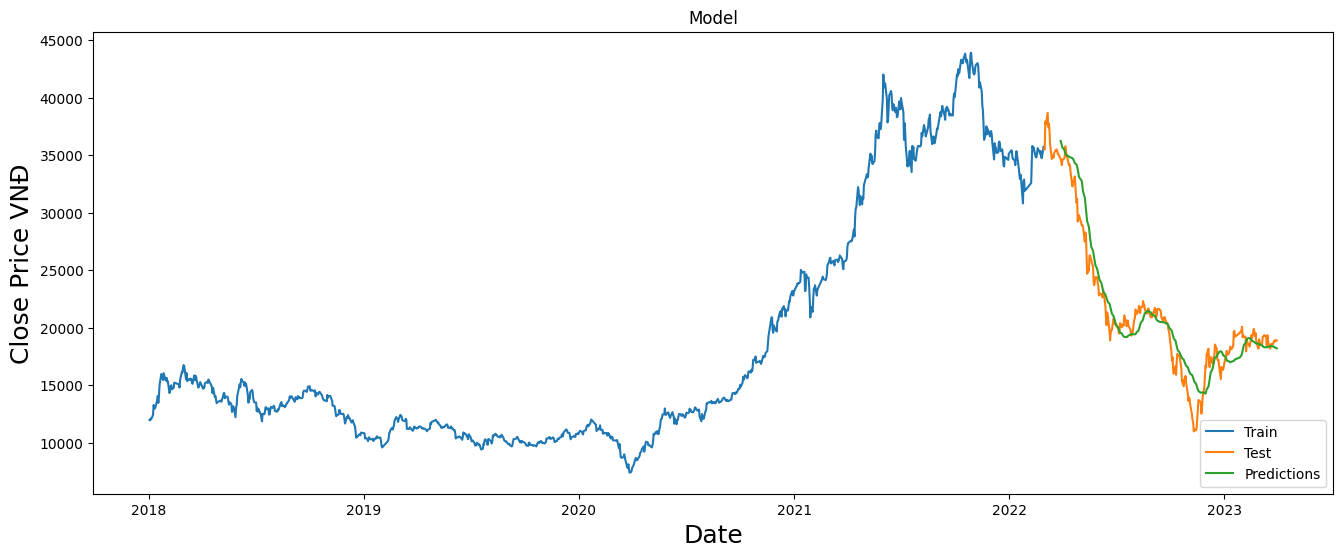

In [ ]:
test['Predictions'] = np.nan
test.iloc[look_back:look_back+len(test_predict_1), test.columns.get_loc('Predictions')] = test_predict_1

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price VNĐ', fontsize=18)
plt.plot(train['Closing Price'], label='Train')
plt.plot(test['Closing Price'], label='Test')
plt.plot(test['Predictions'], label='Predictions')
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()